In [17]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [18]:
transform_augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Lật ngang ngẫu nhiên
    transforms.RandomRotation(10),     # Xoay ngẫu nhiên trong khoảng (-10, 10) độ
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [19]:
batch_size = 4

trainset_augmented = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_augmented
)
trainloader_augmented = torch.utils.data.DataLoader(
    trainset_augmented, batch_size=batch_size, shuffle=True, num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_augmented
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [20]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [22]:
num_epochs = 10
train_loss_history = []
train_accuracy_history = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    model.train()
    for images, labels in trainloader_augmented:
        images, labels = images.to(device), labels.to(device)

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward và update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Ghi nhận kết quả
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Tính toán loss và accuracy
    epoch_loss = running_loss / len(trainloader_augmented)
    epoch_accuracy = 100 * correct / total
    train_loss_history.append(epoch_loss)
    train_accuracy_history.append(epoch_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

Epoch 1/10, Loss: 1.7079, Accuracy: 39.07%
Epoch 2/10, Loss: 1.5482, Accuracy: 44.97%
Epoch 3/10, Loss: 1.4886, Accuracy: 47.71%
Epoch 4/10, Loss: 1.4460, Accuracy: 49.02%
Epoch 5/10, Loss: 1.4175, Accuracy: 50.10%
Epoch 6/10, Loss: 1.3869, Accuracy: 51.44%
Epoch 7/10, Loss: 1.3740, Accuracy: 51.91%
Epoch 8/10, Loss: 1.3615, Accuracy: 52.32%
Epoch 9/10, Loss: 1.3479, Accuracy: 53.02%
Epoch 10/10, Loss: 1.3365, Accuracy: 53.35%


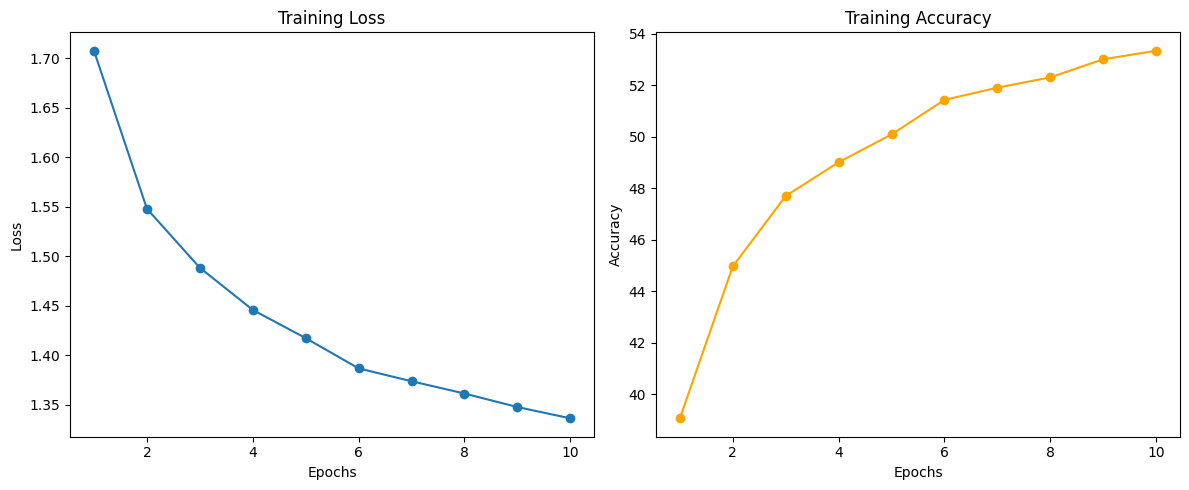

In [23]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss_history, marker='o')
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracy_history, marker='o', color='orange')
plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()

Accuracy on the test set: 51.92%


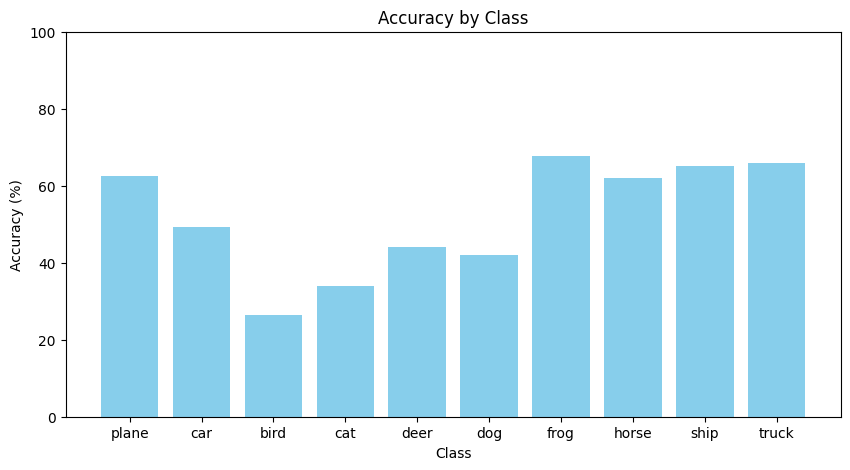

In [24]:
model.eval()
test_correct = 0
test_total = 0
class_correct = [0] * 10
class_total = [0] * 10

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        # Ghi nhận độ chính xác theo lớp
        for label, pred in zip(labels, predicted):
            if label == pred:
                class_correct[label] += 1
            class_total[label] += 1

# Tính độ chính xác tổng thể
test_accuracy = 100 * test_correct / test_total
print(f"Accuracy on the test set: {test_accuracy:.2f}%")

# Độ chính xác theo lớp
class_accuracy = [100 * c / t if t > 0 else 0 for c, t in zip(class_correct, class_total)]

# Vẽ biểu đồ độ chính xác theo lớp
plt.figure(figsize=(10, 5))
plt.bar(range(10), class_accuracy, tick_label=[str(i) for i in classes], color='skyblue')
plt.title("Accuracy by Class")
plt.xlabel("Class")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.show()